# Data Science Assignment 3
## Group 6: Gabriea Groenewegen Van Der Weijden & Arnaud Haaster

### Week 10 preperation:
1. Download the data from https://www.kaggle.com/c/home-depot-product-searchrelevance/data and unzip all files. You now have a directory with four csv files and one docx
file.
2. Import the csv files in Python as separate Pandas dataframes.
3. Read the information on the task and the data. Provide a task definition in your report for
assignment 3

In [1]:
# Importing all necessary packages.
import numpy as np
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
from collections import defaultdict
from scipy.stats import randint, uniform
import time

In [2]:
# Reading the csv files into dataframes.
df_test = pd.read_csv("test.csv", encoding="ISO-8859-1")
df_train = pd.read_csv("train.csv", encoding="ISO-8859-1")
df_attr = pd.read_csv("attributes.csv")
df_sample_sub = pd.read_csv("sample_submission.csv")
df_pro_desc = pd.read_csv("product_descriptions.csv")

#### Data exploration

In [3]:
# Creating a dataframe with all the product-query combinations.
df_proidq = df_train[["product_uid", "search_term"]]

# Creating a dataframe with all the unique product-query combinations.
un_comb = df_proidq.groupby(["product_uid", "search_term"]).size().reset_index().rename(columns={0: "Occurences"})

# Calculating the unique number of products in the training data.
uni_prod = df_train['product_uid'].nunique()

# Calculating the two most occuring products in the training data.
two_most = df_train.groupby("product_uid").size().reset_index().rename(columns={0: "Occurences"}).sort_values(by=["Occurences"], ascending=False).head(2)

# Calculating the descriptive statistics for the relevance values (mean, median,standard deviation) in the training data.
mean_relevance = round(df_train['relevance'].mean(), 2)
median_relevance = round(df_train['relevance'].median(), 2)
std_relevance = round(df_train['relevance'].std(), 2)

# Preparing the data in order to show a histogram or boxplot of the distribution of relevance values in the training data.
df_rel_val = df_train.groupby("relevance").size().reset_index().rename(columns={0: "Occurences"})

# Calculating the top-5 most occurring brand names in the product attributes?
df_brand_name = df_attr.loc[df_attr["name"] == "MFG Brand Name"].rename(columns={"value":"Brand Name"})
df_name_atr = df_brand_name.groupby("Brand Name").size().reset_index().rename(columns={0: "Occurences"}).sort_values(by =["Occurences"], ascending=False).head(6)

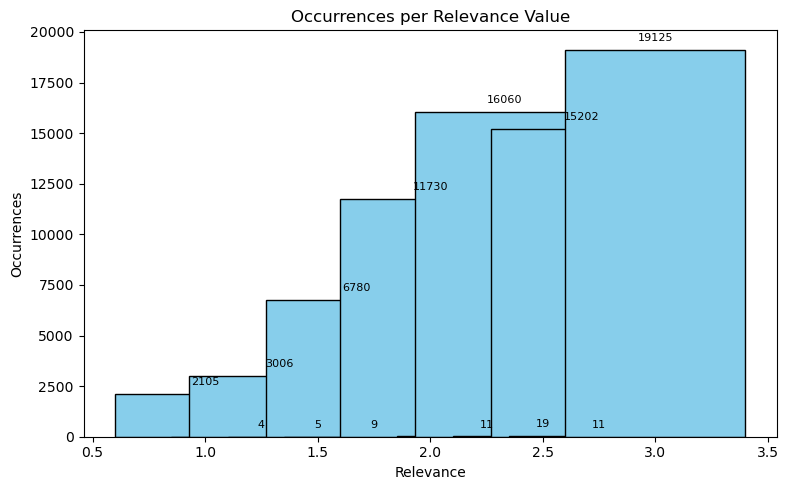

In [4]:
x_val = df_rel_val["relevance"]
y_val = df_rel_val["Occurences"]

# Sort data by relevance
data_sorted = df_rel_val.sort_values("relevance")
x_sorted = data_sorted["relevance"].tolist()
y_sorted = data_sorted["Occurences"].tolist()

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(x_sorted, y_sorted, color='skyblue', edgecolor='black')

ax.set_ylabel('Occurrences')
ax.set_xlabel('Relevance')
ax.set_title('Occurrences per Relevance Value')

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



#### All neccessary functions for the baseline model with extra features implemented.

In [5]:
stemmer = SnowballStemmer('english')
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

# Above is replaced with other overlap weights using the RfidVectorizer package
def tfidf_similarity(str1, str2):
    tfidf = TfidfVectorizer().fit([str1, str2])
    vectors = tfidf.transform([str1, str2])
    return cosine_similarity(vectors[0], vectors[1])[0, 0]

def brand_match_from_dict(search_term, product_uid, brand_dict):
    brand = brand_dict.get(product_uid, '')
    return int(brand in search_term)


In [6]:
# The copy of the baseline model.
num_train = df_train.shape[0]

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

# Initial
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))


""" 
# Added features

# Compute TF-IDF similarity AFTER stemming, which replace the common_word overlap factor
title_vectorizer = TfidfVectorizer()
title_corpus = df_all['product_title'].tolist()
query_corpus = df_all['search_term'].tolist()

# Preparing the matrices for title and query
tfidf_title_matrix = title_vectorizer.fit_transform(title_corpus + query_corpus)
title_tfidf = tfidf_title_matrix[:len(df_all)]
query_tfidf = tfidf_title_matrix[len(df_all):]

desc_vectorizer = TfidfVectorizer()
desc_corpus = df_all['product_description'].tolist()

# Preparing the matrices for description and query
tfidf_desc_matrix = desc_vectorizer.fit_transform(desc_corpus + query_corpus)
desc_tfidf = tfidf_desc_matrix[:len(df_all)]
query_desc_tfidf = tfidf_desc_matrix[len(df_all):]

# Cosine similarity row-by-row using diagonals
df_all['similarity_title'] = [
    cosine_similarity(query_tfidf[i], title_tfidf[i])[0, 0]
    for i in range(query_tfidf.shape[0])
]
df_all['similarity_description'] = [
    cosine_similarity(query_desc_tfidf[i], desc_tfidf[i])[0, 0]
    for i in range(query_desc_tfidf.shape[0])
]


# Adding the feature brand_match
df_brand = df_brand_name[['product_uid', 'Brand Name']].copy()
df_brand['Brand Name'] = df_brand['Brand Name'].fillna('').str.lower()
df_brand['product_uid'] = df_brand['product_uid'].astype(int)

df_brand['Brand Name'] = df_brand['Brand Name'].map(
    lambda brand: " ".join(stemmer.stem(w) for w in brand.split())
)


brand_dict = dict(zip(df_brand['product_uid'], df_brand['Brand Name']))

df_all['brand_match'] = [
    brand_match_from_dict(row['search_term'], row['product_uid'], brand_dict)
    for _, row in df_all.iterrows()
]

# Chekcing fow which products their search terms entailed their brand.
print(df_all[df_all['brand_match'] == 1][['product_uid', 'search_term']].head())

"""
# Final feature processing
# df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)
# df_all['product_info'] = df_all['search_term'] + "\t" + df_all['product_title'] + "\t" + df_all['product_description']


df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test= df_all.iloc[num_train:]
id_test_stem = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test_stem, "relevance": y_pred}).to_csv('submission.csv',index=False)


### Week 11
1. Make a 80-20 split of the training set, using 80% for training and 20% for testing using the
train_test_split function in sklearn.
2. Evaluate the predictions on the test set in terms of Root Mean Squared Error (RMSE). Verify
that your result is close to 0.48. 

The obtained result is your baseline result. Make sure that you use the same train-test split in every
run. Be aware that lower RMSE scores are better.

3. Evaluate the matching without stemming for search terms, product titles, and product
descriptions.

#### Evaluation

In [7]:
# Splitting the train data into 80% of training and 20% testing.

# We are trying to predict the relevance of the tools.
X = df_train.drop(columns=['relevance', 'id', 'product_uid'])
y = df_train['relevance']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

""" Evaluating the predictions on the test set in terms of Root mean squared error. """

# Fitting the model.
clf.fit(X_train, y_train)

# Predictions on the test set.
y_pred_clf = clf.predict(X_test)
rmse_clf = np.sqrt(mean_squared_error(y_test, y_pred_clf))

print("Root Mean Squared Error (RMSE) for clf:", round(rmse_clf, 4))

Root Mean Squared Error (RMSE) for clf: 0.4849


In [8]:
# # Re-reading the csv files into dataframes because the previous ones have been changed.
# df_test = pd.read_csv("test.csv", encoding="ISO-8859-1")
# df_train = pd.read_csv("train.csv", encoding="ISO-8859-1")
# df_attr = pd.read_csv("attributes.csv")
# df_sample_sub = pd.read_csv("sample_submission.csv")
# df_pro_desc = pd.read_csv("product_descriptions.csv")

In [9]:
# # Evaluating the matching without stemming for search terms, product titles, and product descriptions.

# # Rebuild from original inputs
# df_all_nostem = pd.concat((df_train, df_test), axis=0, ignore_index=True)
# df_all_nostem = pd.merge(df_all_nostem, df_pro_desc, how='left', on='product_uid')

# # Lowercasing only (no stemming)
# df_all_nostem['search_term'] = df_all_nostem['search_term'].map(lambda x: x.lower())
# df_all_nostem['product_title'] = df_all_nostem['product_title'].map(lambda x: x.lower())
# df_all_nostem['product_description'] = df_all_nostem['product_description'].map(lambda x: x.lower())

# # Feature engineering
# df_all_nostem['len_of_query'] = df_all_nostem['search_term'].map(lambda x: len(x.split())).astype(np.int64)
# df_all_nostem['product_info'] = df_all_nostem['search_term'] + "\t" + df_all_nostem['product_title'] + "\t" + df_all_nostem['product_description']

# def str_common_word(str1, str2):
#     return sum(int(str2.find(word) >= 0) for word in str1.split())

# df_all_nostem['word_in_title'] = df_all_nostem['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
# df_all_nostem['word_in_description'] = df_all_nostem['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[2]))

# # Drop intermediate text columns
# df_all_nostem = df_all_nostem.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)

# # Split
# df_train_nostem = df_all_nostem.iloc[:num_train]
# df_test_nostem = df_all_nostem.iloc[num_train:]
# id_test = df_test_nostem['id']

# y_train = df_train_nostem['relevance'].values
# X_train = df_train_nostem.drop(['id', 'relevance'], axis=1).values
# X_test = df_test_nostem.drop(['id', 'relevance'], axis=1).values

# # Train and predict
# rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
# clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# # Save result
# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission_no_stemming.csv', index=False)


In [10]:
# # We are trying to predict the relevance of the tools.
# X = df_train_nostem.drop(columns=['relevance', 'id', 'product_uid'])
# y = df_train_nostem['relevance']

# # Split 80% train, 20% test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# """ Evaluating the predictions on the test set in terms of Root mean squared error. """

# # Fitting the models
# clf.fit(X_train, y_train)

# # 2. Predict on the test set
# y_pred_clf = clf.predict(X_test)

# # 3. Compute RMSE
# rmse_clf = np.sqrt(mean_squared_error(y_test, y_pred_clf))
# print("Root Mean Squared Error (RMSE) for clf without stemming:", round(rmse_clf, 4))

#### Improving the matching


Add features for the query-product matching and evaluate the efficacy of each feature. A few
suggestions are:
• Add features for matching query terms to the information in attributes.csv
• Use the structure of the attribute-value pairs to make better informed features
• Replace the simple term count matching functions with other overlap weights. You might
consider using the function TfidfVectorizer in sklearn or the text similarity function in the
spacy package.
Be creative: use any information from the queries and products that might improve the matching

A description of the features you implemented, and an evaluation of the feature sets are part of the
report for assignment 3.

### Week 12
1. Find three other regression models in the sklearn documentation and compare these for the task,
both in quality (RMSE) and processing time. A comparison of the results for four regression models are part of the report for assignment 3.
2. Select the model that works the best. You will now optimize the model’s hyperparameters. In Sklearn
there are some very simple hyper parameter tuning methods: https://scikitlearn.org/stable/modules/grid_search.html . It is also possible to use more advanced methods such
as Bayesian Optimization (https://github.com/wangronin/Bayesian-Optimization/ ).
Make sure you are not optimizing on your test set; you will need to use cross validation on the train
set (e.g using the function RandomizedSearchCV)
3. 

In [11]:
# Code to find the best performing regression model. 
models_list = [DecisionTreeRegressor(random_state=0),LinearRegression(), SVR(), KNeighborsRegressor(), clf]

def model_comparer(model, train_x, train_y, test_x, test_y):
    start_time = time.time()
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    end_time = time.time()
    rmse = np.sqrt(mean_squared_error(test_y, pred_y))

    print(f" For {model} model the mean squared error is {round(rmse,4)} and took the total of {round(end_time - start_time, 2)} seconds.")
    return (model, round(rmse,4), round(end_time - start_time, 2))

results = []
for model in models_list:
    results.append(model_comparer(model, X_train, y_train, X_test, y_test))



 For DecisionTreeRegressor(random_state=0) model the mean squared error is 0.4847 and took the total of 0.01 seconds.
 For LinearRegression() model the mean squared error is 0.4969 and took the total of 0.0 seconds.
 For SVR() model the mean squared error is 0.497 and took the total of 171.9 seconds.
 For KNeighborsRegressor() model the mean squared error is 0.5329 and took the total of 0.22 seconds.
 For BaggingRegressor(estimator=RandomForestRegressor(max_depth=6, n_estimators=15,
                                                 random_state=0),
                 max_samples=0.1, n_estimators=45, random_state=25) model the mean squared error is 0.4849 and took the total of 1.36 seconds.


In [12]:
# Code to optimize the hyper parameters. 
# We need to use cross validation on the train set (e.g.using the function RandomizedSearchCV)
best_model = min(results, key=lambda x:x[1])[0]
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 0,
 'splitter': 'best'}

In [15]:
param_distributions = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': randint(4, 12),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'min_weight_fraction_leaf': uniform(0.0, 0.5),
    'max_features': uniform(0.5, 0.4),
    'max_leaf_nodes': [None] + list(range(10, 100)),
    'min_impurity_decrease': uniform(0.0, 0.01),
    'ccp_alpha': uniform(0.0, 0.005),
    'splitter': ['best', 'random'],
    'random_state': randint(0, 100)
}



In [16]:
# RandomizedSearchCV setup
base_model = DecisionTreeRegressor(random_state=0)
search = RandomizedSearchCV(
    best_model,
    param_distributions=param_distributions,
    n_iter=200,  # You can adjust this
    cv=8,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the search only on training data
search.fit(X_train, y_train)

# Best model and hyperparameters
best_model = search.best_estimator_
print("Best hyperparameters:\n", search.best_params_)

Fitting 8 folds for each of 200 candidates, totalling 1600 fits
[CV] END ccp_alpha=0.0018727005942368125, criterion=squared_error, max_depth=10, max_features=0.7927975767245621, max_leaf_nodes=69, min_impurity_decrease=0.00596850157946487, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.04998745790900144, random_state=74, splitter=random; total time=   0.0s
[CV] END ccp_alpha=0.0018727005942368125, criterion=squared_error, max_depth=10, max_features=0.7927975767245621, max_leaf_nodes=69, min_impurity_decrease=0.00596850157946487, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.04998745790900144, random_state=74, splitter=random; total time=   0.0s
[CV] END ccp_alpha=0.0018727005942368125, criterion=squared_error, max_depth=10, max_features=0.7927975767245621, max_leaf_nodes=69, min_impurity_decrease=0.00596850157946487, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.04998745790900144, random_state=74, splitter=random; total t

In [17]:


start_time = time.time()
model = best_model
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
end_time = time.time()
rmse = np.sqrt(mean_squared_error(y_test, pred_y))

print(f" For {model} model the mean squared error is {round(rmse,4)} and took the total of {round(end_time - start_time, 2)} seconds.")


 For DecisionTreeRegressor(ccp_alpha=np.float64(0.0007005658788322627),
                      criterion='friedman_mse', max_depth=9,
                      max_features=np.float64(0.6949724792998054),
                      max_leaf_nodes=95,
                      min_impurity_decrease=np.float64(0.007998552559473153),
                      min_samples_split=3,
                      min_weight_fraction_leaf=np.float64(0.011234654160058699),
                      random_state=13) model the mean squared error is 0.4883 and took the total of 0.02 seconds.


In [ ]:
finetuned_parameters = model 